### 根据质量求解密度

$$l_i = x_{i+1/2} - x_{i-1/2}$$
$$\rho = m/l$$
$$e = \frac{p}{(\gamma -1)\rho}$$

### 添加人工粘性

$$p = p + q$$
$$q_i = \left\{ \begin{aligned}
1.5\rho_il_ic_i|\frac{\partial u}{\partial x}|
            +0.06\rho_il_i^2\left(\frac{\partial u}{\partial x}\right)^2  \quad \text{if} \quad \frac{\partial u}{\partial x} <0\\
            0 \text{else}
            \end{aligned} \right.
            $$

### 右端项

$$\text{rhsu}_{i+1/2} = -\frac{(p_{i+1}- p_i)}{m_{p,i+1/2}}$$
$$\text{rhse}_i = -\frac{p_i(u_{i+1/2}-u_{i-1/2})}{m_i}$$

$$m_{p,i+1/2} \approx \frac{m_{i}+m_{i+1}}{2}$$

### 推进

$$ x  = x +dt* u$$
$$ u = u + dt* \text{rhsu}$$
$$ e = e + dt* \text{rhse}$$

### 求解新的密度和压力

$$l_i = x_{i+1/2} - x_{i-1/2}$$
$$\rho = m/l$$
$$ p = (\gamma -1)\rho e$$


In [1]:
function init()
    I = 300
    u = zeros(Float64,I+1)
    x = zeros(Float64,I+1)
    l = zeros(Float64,I)
    p = zeros(Float64,I)
    ρ = zeros(Float64,I)
    m = zeros(Float64,I)
    e = zeros(Float64,I)
    γ = 1.4
    
    Δx = 1.0/I
    l .= Δx
    
    tt = 0.14
    sf =0.1
    # init
    
    for i in 1:I 
        u[i] = 0
        
        
        if i >I/2
            p[i] = 0.1
            ρ[i] = 0.125
            m[i] =ρ[i]*Δx
        else
            p[i] = 1.0
            ρ[i] = 1.0
            m[i] = ρ[i]*Δx
        end
    end
    
    for i in 1:I+1
        x[i] = i*Δx
    end
    
    
    e = pToe(p,ρ,γ)
return sf,tt,γ,u,x,m,p
end

            
            

init (generic function with 1 method)

In [2]:
function pToe(p,ρ,γ)
    return p ./ ρ/(γ-1)
end
function eTop(e,ρ,γ)
    return (γ-1)*ρ .* e
end

eTop (generic function with 1 method)

In [3]:
function timeSolve(sf, tt,γ,u,x,m,p)
    t= 0.0

    I, = size(m)
    ρ = zeros(Float64,I)
       while t<tt
#for i in 1:1
        dt=CFL(sf,γ,x,u,p,m)
        if t+dt>tt
           dt = tt-t
        end
        u,x,p,ρ = Euler1st(γ,dt,u,x,p,m)
        t += dt
        
        println(t)
    end
#
    return u,x,p,ρ
end

timeSolve (generic function with 1 method)

In [4]:
function pre2nd(γ,dt,u,x,p,m)
    I, = size(p)
    
    l = zeros(Float64,I)
    x₀ = zeros(Float64,I+1)
    u₀ = zeros(Float64,I+1)
    e₀ = zeros(Float64,I)
    
     for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l     
    e = pToe(p, ρ,γ)    
    
    p = artificial_viscosity!(γ,l,p,ρ,x,u) 
      
    rhsu, rhse = Rhs(x,l,u,p,m)
  
    x₀  = x+ dt .* u
    u₀  = u+ dt .* rhsu
    e₀  = e+ dt .* rhse
    

    
    for i in 1:I
        l[i] = x₀[i+1]-x₀[i]
    end
    
    ρ = m ./ l
    p = eTop(e, ρ,γ)
#    p = artificial_viscosity!(γ,l,p,ρ,x₀,u₀)
    
    rhsu₀, rhse₀ = Rhs(x₀,l,u₀,p,m)
    
    x  += 1/2 *dt*(u +u₀)
    u  += 1/2 *dt*(rhsu + rhsu₀)
    e  += 1/2 *dt*(rhse + rhse₀)
    
    for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l
    p = eTop(e, ρ,γ)
    
    
    return u,x,p,ρ
end

pre2nd (generic function with 1 method)

In [5]:
function Euler1st(γ,dt,u,x,p,m)
    I, = size(p)
    
    l = zeros(Float64,I)
    x₀ = zeros(Float64,I+1)
    u₀ = zeros(Float64,I+1)
    e₀ = zeros(Float64,I)
    
     for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l     
    e = pToe(p, ρ,γ)    
    
    p = artificial_viscosity!(γ,l,p,ρ,x,u) 
      
    rhsu, rhse = Rhs(x,l,u,p,m)
  
    x  = x+ dt .* u
    u  = u+ dt .* rhsu
    e  = e+ dt .* rhse    
    
    for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l
    p = eTop(e, ρ,γ)
    
    
    return u,x,p,ρ
end


Euler1st (generic function with 1 method)

## 预估校正方法 （二阶）

$$\frac{dy}{dx} = f(x,y)$$

$$y_0 = y_n + dx f(x_n,y_n)$$

$$y_{n+1} = y_n + \frac{1}{2} dx [f(x_n, y_n) + f(x_{n+1},y_0)] $$

In [6]:
function Rhs(x,l,u,p,m)
    I, = size(m)
    rhsu = zeros(Float64,I+1)
    rhse = zeros(Float64,I)
    for i in 1:I-1
        rhsu[i+1] = - 2(p[i+1] - p[i])/(m[i] +m[i+1])
    end
    for i in 1:I
        rhse[i] = - p[i]*(u[i+1]-u[i])/m[i]
    end

    return rhsu,rhse
    
    end
    

Rhs (generic function with 1 method)

In [7]:
function artificial_viscosity!(γ, l,p,ρ,x,u)
    I, = size(p)
    for i in 1:I
        c = √(γ*p[i]/ρ[i])
        ∂u_∂x = (u[i+1]- u[i])/(x[i+1]-x[i])
        q = 0
        if ∂u_∂x < 0 
        q = 1.5ρ[i]*l[i]*c*abs(∂u_∂x)
            +2.5ρ[i]*l[i]^2*(∂u_∂x)^2 
        end
        p[i] = p[i] +q
    
    end
    return p
end

artificial_viscosity! (generic function with 1 method)

In [9]:
  function CFL(sf,γ,x,u,p,m)
    dlmin = 1e8
    umax = 0.0
    I, = size(p)
    l = zeros(Float64,I)
    ρ = zeros(Float64,I)
    
     for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l
    for i in 1:I
        c  = √(γ*p[i]/ρ[i])
        u2 = u[i] + c 
        if abs(u2) > umax
            umax = abs(u2)
        end
        if l[i] < dlmin
            dlmin = l[i]
        end
    end
    cfl = dlmin/umax*sf
    return cfl
end

CFL (generic function with 1 method)

In [10]:
sf,tt,γ,u,x,m,p = init()
u,x,p,ρ = timeSolve(sf, tt, γ, u, x, m,p)

0.00028171808490949944
0.0005610027886476087
0.0008094206882423757
0.0010335715439813216
0.0012381665020248338
0.0014266771434902404
0.0016017335300011046
0.0017653770214548985
0.001919225647023627
0.002064585281388527
0.0022025263446678943
0.002333938016456118
0.0024595674298155254
0.002580048601372663
0.0026959241951172545
0.0028076621805780974
0.00291566878429897
0.003020298702751348
0.00312186325899001
0.003220636992214886
0.00331686303660197
0.003410757552934062
0.003502513410645837
0.003592303270396412
0.003680282182572475
0.003766589791428361
0.003851352215312335
0.0039346836588317075
0.0040166878016278775
0.0040974589997822405
0.0041770833291212015
0.004255639494372277
0.004333199623905275
0.004409829966421587
0.004485591503242287
0.004560540487649515
0.0046347289209465615
0.004708204973436221
0.004781013357309266
0.004853195657434409
0.0049247906252076565
0.004995834439920943
0.005066360941522148
0.005136401838140725
0.0052059868913293585
0.005275144081609008
0.005343899756592

0.03670570461024854
0.03677703356970854
0.03684835793258515
0.036919677784838706
0.03699099320986188
0.03706230428855568
0.03713361109940359
0.037204913718544036
0.03727621221984099
0.03734750667495304
0.03741879715340076
0.037490083722632475
0.03756136644808845
0.03763264539326359
0.03770392061976863
0.037775192187389846
0.03784646015414737
0.03791772368536211
0.03798898080032791
0.038060231629053136
0.03813147629804337
0.03820271493040351
0.038273947645937056
0.03834517456124275
0.03841639578980852
0.03848761144210289
0.03855882162566386
0.03863002644518544
0.03870122600260171
0.03877242039716868
0.0388436097255439
0.03891479408186383
0.03898597355781922
0.03905714824272832
0.03912831822360815
0.039199483585243784
0.03927064441025579
0.039341800779165735
0.03941295277046
0.03948410046065175
0.039555243924341205
0.03962638323427432
0.03969751846139977
0.03976864967492434
0.03983977694236687
0.03991090032961058
0.03998201990095401
0.04005313571916049
0.04012424784550623
0.0401953563398

0.07262404978857659
0.07269419540785803
0.07276434011027666
0.0728344839056794
0.07290462680373394
0.07297476881393279
0.07304490994559723
0.07311505020788117
0.07318518960977491
0.0732553281601088
0.07332546586755684
0.07339560274064014
0.07346573878773036
0.07353587401705301
0.07360600843669068
0.07367614205458622
0.0737462748785458
0.07381640691624196
0.07388653817521645
0.0739566686628832
0.07402679838653102
0.0740969273533264
0.0741670555703161
0.07423718304442972
0.07430730978248234
0.07437743579117687
0.07444756107710647
0.07451768564675695
0.074587809506509
0.07465793266264047
0.07472805512132848
0.0747981768886516
0.07486829797059191
0.07493841837303701
0.07500853810178199
0.0750786571271605
0.07514877531776697
0.07521889268239272
0.07528900922967066
0.07535912496807874
0.07542923990594337
0.07549935405144273
0.07556946741261003
0.07563957999733667
0.07570969181337535
0.07577980286834304
0.07584991316972399
0.07592002272487255
0.07599013154101601
0.07606023962525732
0.07613034

0.10888935255756249
0.10895927912918785
0.1090292055101305
0.10909913170108168
0.10916905770272768
0.10923898351574994
0.10930890914082508
0.109378834578625
0.10944875982981693
0.10951868488919347
0.10958860974924133
0.10965853441074107
0.10972845887446675
0.109798383141186
0.10986830721166017
0.10993823108664436
0.11000815476688755
0.11007807825313275
0.110148001546117
0.1102179246465715
0.11028784755522177
0.1103577702727876
0.11042769279998327
0.11049761513751755
0.1105675372860938
0.11063745924641008
0.11070738101915921
0.11077730260502885
0.11084722400470158
0.11091714521885494
0.11098706624816158
0.11105698709328927
0.11112690775490099
0.11119682823365497
0.11126674853020482
0.11133666864519957
0.11140658857928372
0.11147650833309729
0.11154642790727592
0.11161634730245094
0.11168626651924937
0.11175618555829404
0.11182610442020365
0.11189602310559274
0.11196594161507187
0.11203585994924757
0.11210577810872248
0.11217569609409532
0.11224561390596102
0.11231553154491071
0.11238544

([0.0, -1.89897e-16, -3.78325e-16, 1.04479e-16, -1.04479e-16, 0.0, 0.0, 0.0, 1.28712e-16, -1.28712e-16  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.00333333, 0.00666667, 0.01, 0.0133333, 0.0166667, 0.02, 0.0233333, 0.0266667, 0.03, 0.0333333  …  0.973333, 0.976667, 0.98, 0.983333, 0.986667, 0.99, 0.993333, 0.996667, 1.0, 1.00333], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

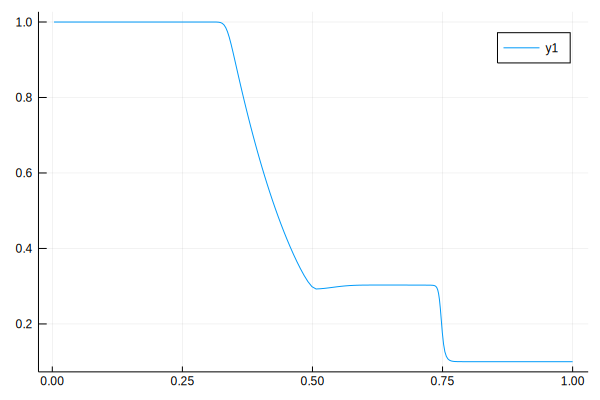

In [12]:
using Plots
plot(x[1:end-1],p)
# plot!(x[1:end-1],p)
# plot!(x[1:end],u)
# plot!(x1 .+ 0.5,U[:,1:3])

In [100]:
push!(LOAD_PATH, "/home/bfly/workspace/computeforcfd/Lag2D/")

6-element Array{String,1}:
 "@"                                        
 "@v#.#"                                    
 "@stdlib"                                  
 "/home/bfly/workspace/computeforcfd/Lag2D/"
 "/home/bfly/workspace/computeforcfd/Lag2D/"
 "/home/bfly/workspace/computeforcfd/Lag2D/"

In [10]:
using Riemann

In [312]:
Wₗ = W(1.0,0.0,1.0)
Wᵣ = W(0.125,0.0,0.1)
γ = 1.4
x1,U = SolveDistr(0.14,Wₗ,Wᵣ,γ)

([-0.3313, -0.330472, -0.329644, -0.328816, -0.327987, -0.327159, -0.326331, -0.325503, -0.324674, -0.323846  …  0.478339, 0.479565, 0.480792, 0.482018, 0.483245, 0.484471, 0.485698, 0.486924, 0.488151, 0.489377], [1.0 0.0 1.0; 1.0 0.0 1.0; … ; 0.125 0.0 0.1; 0.125 0.0 0.1])

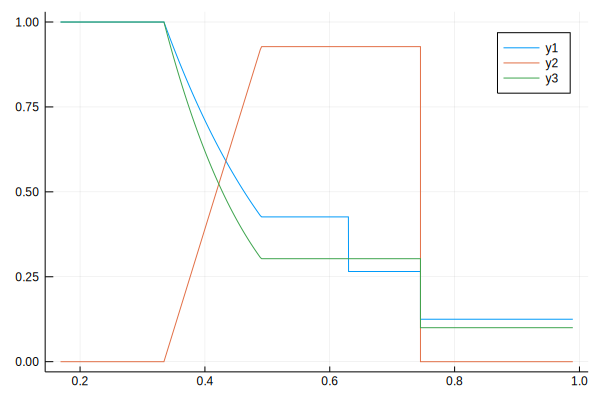

In [313]:
plot(x1 .+ 0.5,U)